In [1]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
# SVM
from sklearn import svm
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Data Preparation


Prepare the data to be used with kNN

In [2]:
plots = [("traces/normal/", 'grid_normal_2019-02-19_21'),
         ("traces/1bh-7/", 'grid_1bh-7_2019-02-19_22'),
         ("traces/1bh-9/", 'grid_1bh-9_2019-02-20_00'),
         ("traces/1gh30-7/", 'grid_1gh30-7_2019-02-19_22'),
         ("traces/1gh30-9/", 'grid_1gh30-9_2019-02-20_00'),
         ("traces/1gh50-7/", 'grid_1gh50-7_2019-02-19_22'),
         ("traces/1gh50-9/", 'grid_1gh50-9_2019-02-19_23'),
         ("traces/1gh70-7/", 'grid_1gh70-7_2019-02-19_23'),
         ("traces/1gh70-9/", 'grid_1gh70-9_2019-02-19_23')
        ]

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    experiment = row[0].split('/')[1]
    
    # Assign a label
    if row[0].find('gh') >= 0:
        label = 'Gray Hole'
    elif row[0].find('bh') >= 0:
        label = 'Black Hole'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,count,mean,var,std,hop,min,max,loss,label
0,aaaa::212:7403:3:303:,148,128.785811,14261.209389,119.420306,1,41.1,947.0,0.260,Normal
1,aaaa::212:7408:8:808:,97,295.701031,73333.878436,270.802287,2,103.0,1809.0,0.515,Normal
2,aaaa::212:7402:2:202:,160,316.326875,100885.449147,317.624699,2,77.9,1858.0,0.200,Normal
3,aaaa::212:740a:a:a0a:,115,433.895652,95800.515332,309.516583,4,188.0,2237.0,0.425,Normal
4,aaaa::212:7409:9:909:,110,549.300000,151722.799083,389.516109,3,168.0,1606.0,0.450,Normal


Select the set of features and labels that we use to fit the algorithm

In [3]:
# separate features from target values
features = stats.drop(columns=['node_id', 'experiment', 'label'])
target = stats['label'].values
print('Targets: ' + str(set(target)))

# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

Targets: {'Black Hole', 'Gray Hole', 'Normal'}


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

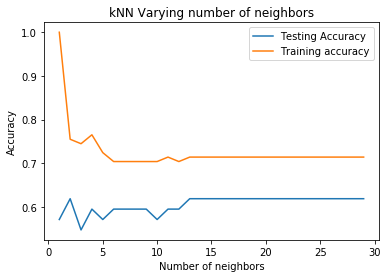

In [25]:
trace_analysis.knn_test_number_of_neighbors(X_train, X_test, y_train, y_test)

Let's build KNN classifier 

In [26]:
#Create KNN Classifier
knn_clf = KNeighborsClassifier(n_neighbors=15)

#Train the model using the training sets
knn_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))


Accuracy: 0.6190476190476191


               precision    recall  f1-score   support

  Black Hole       0.00      0.00      0.00        12
   Gray Hole       0.62      1.00      0.76        26
      Normal       0.00      0.00      0.00         4

   micro avg       0.62      0.62      0.62        42
   macro avg       0.21      0.33      0.25        42
weighted avg       0.38      0.62      0.47        42



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [12]:
cv_results = None

# Select the set of features and labels that we use to fit the algorithm
for trace_size in trace_stats:
    print('Computing trace {}'.format(trace_size))
    trace = trace_stats[trace_size]
    # separate features from target values
    features = trace.drop(columns=['node_id', 'experiment', 'label'])
    target = trace['label'].values
    
    # split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    
    #Create KNN Classifier
    knn_clf = KNeighborsClassifier(n_neighbors=15)
    
    #train model with cv of 5
    cv_scores = cross_val_score(knn_clf, features, target, cv = 5)
    
    if cv_results is None:
        cv_results = pd.DataFrame({'Model': ['KNN'], 
                                   'Window Size': [trace_size], 
                                   'Mean Accuracy': [np.mean(cv_scores)]})
    else:
        cv_results = pd.concat([cv_results, pd.DataFrame({'Model': ['KNN'], 
                                             'Window Size': [trace_size], 
                                             'Mean Accuracy': [np.mean(cv_scores)]})])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [13]:
#Create a svm Classifier
svm_clf = svm.SVC(kernel='linear', random_state=9, gamma='scale') # Linear Kernel

#Train the model using the training sets
svm_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svm_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))

Accuracy: 0.6666666666666666


               precision    recall  f1-score   support

  Black Hole       0.62      0.42      0.50        12
   Gray Hole       0.68      0.88      0.77        26
      Normal       0.00      0.00      0.00         4

   micro avg       0.67      0.67      0.67        42
   macro avg       0.43      0.43      0.42        42
weighted avg       0.60      0.67      0.62        42



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [14]:
# Select the set of features and labels that we use to fit the algorithm
for trace_size in trace_stats:
    print('Computing trace {}'.format(trace_size))
    trace = trace_stats[trace_size]
    # separate features from target values
    features = trace.drop(columns=['node_id', 'experiment', 'label'])
    target = trace['label'].values
    
    # split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    
    #Create SVM Classifier
    svm_clf = svm.SVC(kernel='linear', random_state=9, gamma='scale') # Linear Kernel
    
    #train model with cv of 5
    cv_scores = cross_val_score(svm_clf, features, target, cv = 5)
    
    if cv_results is None:
        cv_results = pd.DataFrame({'Model': ['SVM'], 
                                   'Window Size': [trace_size], 
                                   'Mean Accuracy': [np.mean(cv_scores)]})
    else:
        cv_results = pd.concat([cv_results, pd.DataFrame({'Model': ['SVM'], 
                                             'Window Size': [trace_size], 
                                             'Mean Accuracy': [np.mean(cv_scores)]})])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

No handles with labels found to put in legend.


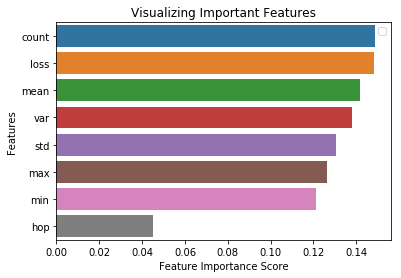

In [15]:
trace_analysis.random_forests_features_selection(X_train, X_test, y_train, y_test, features)

Select relevant features

In [16]:
# separate features from target values
features = stats.drop(columns=['node_id', 'experiment', 'label', 'hop'])
target = stats['label'].values
print('Targets: ' + str(set(target)))

# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

Targets: {'Gray Hole', 'Black Hole', 'Normal'}


Predicted values

In [17]:
#Create a Gaussian Classifier
rf_clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_clf.fit(X_train,y_train)

y_pred = rf_clf.predict(X_test)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))

Accuracy: 0.5952380952380952


               precision    recall  f1-score   support

  Black Hole       0.00      0.00      0.00        12
   Gray Hole       0.61      0.96      0.75        26
      Normal       0.00      0.00      0.00         4

   micro avg       0.60      0.60      0.60        42
   macro avg       0.20      0.32      0.25        42
weighted avg       0.38      0.60      0.46        42



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [16]:
# Select the set of features and labels that we use to fit the algorithm
for trace_size in trace_stats:
    print('Computing trace {}'.format(trace_size))
    trace = trace_stats[trace_size]
    # separate features from target values
    features = trace.drop(columns=['node_id', 'experiment', 'label', 'hop'])
    target = trace['label'].values
    print('Targets: ' + str(set(target)))

    # split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    
    #Create Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=100)
    
    #train model with cv of 5
    cv_scores = cross_val_score(rf_clf, features, target, cv = 5)
    
    if cv_results is None:
        cv_results = pd.DataFrame({'Model': ['Random Forest'], 
                                   'Window Size': [trace_size], 
                                   'Mean Accuracy': [np.mean(cv_scores)]})
    else:
        cv_results = pd.concat([cv_results, pd.DataFrame({'Model': ['Random Forest'], 
                                             'Window Size': [trace_size], 
                                             'Mean Accuracy': [np.mean(cv_scores)]})])

Computing trace 200
Targets: {'Black Hole', 'Gray Hole', 'Normal'}
Computing trace 25
Targets: {'Black Hole', 'Gray Hole', 'Normal'}
Computing trace 50
Targets: {'Black Hole', 'Gray Hole', 'Normal'}
Computing trace 100
Targets: {'Black Hole', 'Gray Hole', 'Normal'}


# Results

Here we plot the average results for each model

In [31]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,KNN,200,0.576720
1,KNN,25,0.631953
2,KNN,50,0.621253
3,KNN,100,0.631789
4,SVM,200,0.622646
5,SVM,25,0.590432
6,SVM,50,0.601763
7,SVM,100,0.597560
8,Random Forest,200,0.497725
9,Random Forest,25,0.596201
